In [1]:
import pandas as pd
import numpy as np

users = pd.read_csv(
    "users.csv",
    parse_dates=["signup_date"],
    keep_default_na=False,        # do NOT auto-convert 'NA', 'N/A', etc. to NaN
    na_values=["", " ", "NaN"]    # still treat true blanks as missing
)

# (optional) normalise/spaces -> NA
users = users.apply(
    lambda s: s.replace(r"^\s*$", pd.NA, regex=True) if s.dtype == "object" else s
)

# sanity check
print(users["region"].value_counts(dropna=False))
print("Missing % in region:", users["region"].isna().mean())

region
NA       38224
APAC     27810
EU       25960
LATAM     8006
Name: count, dtype: int64
Missing % in region: 0.0


In [2]:
import pandas as pd

# Helper: keep "NA" literal, but treat blanks and "N/A" as missing
NA_SAFE = dict(
    keep_default_na=False,                 # don't auto-convert "NA"/"na" to NaN
    na_values=["", " ", "NaN", "nan", "N/A", "n/a"]  # still treat true blanks & "N/A" as NaN
)

# Load CSVs (dates parsed as before)
users    = pd.read_csv("users.csv", parse_dates=["signup_date"], **NA_SAFE)
sessions = pd.read_csv("sessions.csv", parse_dates=["session_start", "session_end"], **NA_SAFE)
events   = pd.read_csv("events.csv", parse_dates=["ts"], **NA_SAFE)
billing  = pd.read_csv("billing.csv", parse_dates=["month"], **NA_SAFE)

# Optional: convert whitespace-only strings to NA across object columns (safety net)
for df in (users, sessions, events, billing):
    obj_cols = df.select_dtypes(include="object").columns
    df[obj_cols] = df[obj_cols].replace(r"^\s*$", pd.NA, regex=True)

# Quick sanity check that "NA" is kept as a category, not NaN
print(users["region"].value_counts(dropna=False).head(10))
print("Missing % in region:", users["region"].isna().mean())


region
NA       38224
APAC     27810
EU       25960
LATAM     8006
Name: count, dtype: int64
Missing % in region: 0.0


In [3]:
# 30-day churn rate
churn_rate_30d = users["churned_30d"].mean()
print(f"30-day churn rate: {churn_rate_30d:.2%}")

# 90-day churn rate
churn_rate_90d = users["churned_90d"].mean()
print(f"90-day churn rate: {churn_rate_90d:.2%}")



30-day churn rate: 12.96%
90-day churn rate: 22.99%


In [4]:
# Aggregate sessions per user
session_stats = sessions.groupby("user_id").agg(
    sessions_count=("session_id", "count"),
    avg_session_length=("session_length_sec", "mean")
).reset_index()

# Merge with 30d + 90d churn labels
engagement = users[["user_id", "churned_30d", "churned_90d"]] \
    .merge(session_stats, on="user_id", how="left")

# Compare churned vs retained (30d)
print("Engagement by 30d churn status:\n")
print(engagement.groupby("churned_30d")[["sessions_count", "avg_session_length"]].mean())

# Compare churned vs retained (90d)
print("\nEngagement by 90d churn status:\n")
print(engagement.groupby("churned_90d")[["sessions_count", "avg_session_length"]].mean())


Engagement by 30d churn status:

             sessions_count  avg_session_length
churned_30d                                    
0                  4.864032          839.461520
1                  3.482207          839.124266

Engagement by 90d churn status:

             sessions_count  avg_session_length
churned_90d                                    
0                  5.083332          839.376957
1                  3.007022          839.632376


In [5]:
session_stats = sessions.groupby("user_id").agg(
    avg_session_length=("session_length_sec", "mean"),
    sessions_per_week=("session_id", lambda x: float(x.nunique())/4),
    active_days=("session_start", lambda x: float(x.dt.date.nunique())),
    device_diversity=("device", "nunique"),
    os_diversity=("os", "nunique")
).reset_index()

print(session_stats[["sessions_per_week"]])


       sessions_per_week
0                   0.25
1                   0.25
2                   1.00
3                   0.50
4                   1.25
...                  ...
71528               2.75
71529               2.25
71530               0.50
71531               2.25
71532               1.25

[71533 rows x 1 columns]


In [6]:
import numpy as np
import pandas as pd

# Ensure datetime
sessions = sessions.copy()
sessions["session_start"] = pd.to_datetime(sessions["session_start"])

# (Optional) de-dup in case the same session_id appears multiple times
sessions = sessions.drop_duplicates(subset=["user_id", "session_id"])

# Per-user aggregates
g = sessions.groupby("user_id")

session_stats = g.agg(
    sessions_count=("session_id", "nunique"),
    avg_session_length=("session_length_sec", "mean"),
    first_seen=("session_start", "min"),
    last_seen=("session_start", "max"),
    active_days=("session_start", lambda x: x.dt.date.nunique()),
    device_diversity=("device", "nunique"),
    os_diversity=("os", "nunique")
).reset_index()

# Compute weeks observed per user (avoid divide-by-zero for single-day users)
span_days = (session_stats["last_seen"] - session_stats["first_seen"]).dt.total_seconds() / 86400.0
weeks_observed = np.maximum(span_days / 7.0, 1/7)   # at least one day (~1/7 week)

session_stats["sessions_per_week"] = session_stats["sessions_count"] / weeks_observed

# Inspect
session_stats[["user_id", "sessions_count", "first_seen", "last_seen", "sessions_per_week"]].head()


,user_id,sessions_count,first_seen,last_seen,sessions_per_week
0,0000093e-7258-43c0-b212-ea7212795ddf,1,2025-04-04 22:01:25.065312987,2025-04-04 22:01:25.065312987,7.000000
1,0006fdbd-c35d-4c0d-a948-e8ee10f279d5,1,2025-02-12 23:47:41.761338189,2025-02-12 23:47:41.761338189,7.000000
2,0007ee13-0c60-4865-9464-914b2df654df,4,2025-03-21 12:50:37.457893086,2025-06-06 10:27:59.068288586,0.364105
3,000836d5-0777-4310-a8a5-5c857d2ea5e5,2,2024-07-15 12:25:29.926266202,2024-09-15 23:33:35.673589849,0.224129
4,0008a782-5378-45a1-b332-10c73c4296ff,5,2025-02-20 17:05:06.077705968,2025-07-06 16:15:29.456901849,0.257418


In [7]:
# Event stats per user (30D)
event_stats = events.groupby("user_id").agg(
    fail_rate=("success", lambda x: 1 - x.mean()),
    avg_latency=("latency_ms", "mean"),
    features_used=("feature_name", "nunique")
).reset_index()

exp = users[["user_id", "churned_30d"]].merge(event_stats, on="user_id", how="left")

print(exp.groupby("churned_30d")[["fail_rate", "avg_latency", "features_used"]].mean())

# Event stats per user (90D)
event_stats = events.groupby("user_id").agg(
    fail_rate=("success", lambda x: 1 - x.mean()),
    avg_latency=("latency_ms", "mean"),
    features_used=("feature_name", "nunique")
).reset_index()

exp = users[["user_id", "churned_90d"]].merge(event_stats, on="user_id", how="left")

print(exp.groupby("churned_90d")[["fail_rate", "avg_latency", "features_used"]].mean())

             fail_rate  avg_latency  features_used
churned_30d                                       
0             0.069980   258.354448        2.07476
1             0.071522   275.063462        1.82014
             fail_rate  avg_latency  features_used
churned_90d                                       
0             0.070276   255.355131       2.106863
1             0.069418   285.484804       1.734101


In [8]:
# Aggregate billing by user (30D) in percentage 
billing_stats = billing.groupby("user_id").agg(
    overdue=("invoices_overdue", "mean"),
    discount=("discount_applied", "mean"),
    avg_tickets=("support_ticket_count", "mean")
).reset_index()

bill = users[["user_id", "churned_30d"]].merge(billing_stats, on="user_id", how="left")

print(bill.groupby("churned_30d")[["overdue", "discount", "avg_tickets"]].mean())

# Aggregate billing by user (90D)
billing_stats = billing.groupby("user_id").agg(
    overdue=("invoices_overdue", "mean"),
    discount=("discount_applied", "mean"),
    avg_tickets=("support_ticket_count", "mean")
).reset_index()

bill = users[["user_id", "churned_90d"]].merge(billing_stats, on="user_id", how="left")

print(bill.groupby("churned_90d")[["overdue", "discount", "avg_tickets"]].mean())



              overdue  discount  avg_tickets
churned_30d                                 
0            0.024312  0.071200     0.497307
1            0.026551  0.047302     0.296783
              overdue  discount  avg_tickets
churned_90d                                 
0            0.023842  0.077167     0.540442
1            0.027146  0.037744     0.239792


In [9]:
# Churn by plan tier (30D)
seg_30 = users.groupby("plan_tier")["churned_30d"].mean()
print("30D churn by plan tier:\n", seg_30)

# Churn by acquisition channel (30D)
seg2_30 = users.groupby("acquisition_channel")["churned_30d"].mean()
print("30D churn by acquisition channel:\n", seg2_30)

# Churn by plan tier (90D)
seg_90 = users.groupby("plan_tier")["churned_90d"].mean()
print("90D churn by plan tier:\n", seg_90)

# Churn by acquisition channel (90D)
seg2_90 = users.groupby("acquisition_channel")["churned_90d"].mean()
print("90D churn by acquisition channel:\n", seg2_90)



30D churn by plan tier:
 plan_tier
free        0.165465
premium     0.058785
standard    0.099987
Name: churned_30d, dtype: float64
30D churn by acquisition channel:
 acquisition_channel
ads         0.137432
outbound    0.133694
partner     0.124769
seo         0.125666
Name: churned_30d, dtype: float64
90D churn by plan tier:
 plan_tier
free        0.318936
premium     0.063667
standard    0.151543
Name: churned_90d, dtype: float64
90D churn by acquisition channel:
 acquisition_channel
ads         0.236924
outbound    0.237952
partner     0.223436
seo         0.226044
Name: churned_90d, dtype: float64


In [10]:
# If needed (once):
# !pip install imbalanced-learn xgboost packaging

import numpy as np
import pandas as pd
import sklearn
from packaging import version

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # <-- imblearn Pipeline (required for SMOTE step)
from xgboost import XGBClassifier

RANDOM_STATE = 42
TEST_SIZE = 0.20
LABEL = "churned_90d"   # change to "churned_30d" if you want 30-day churn


In [11]:
def load_csv_safe(path, parse_dates=None):
    df = pd.read_csv(
        path,
        parse_dates=parse_dates or [],
        keep_default_na=False,       # keep "NA" literal (North America), don't auto-NaN it
        na_values=["", " ", "NaN"]   # treat real blanks as missing
    )
    # replace whitespace-only strings with NA, but keep "NA"
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].replace(r"^\s*$", pd.NA, regex=True)
    return df

users    = load_csv_safe("users.csv",    ["signup_date"])
sessions = load_csv_safe("sessions.csv", ["session_start", "session_end"])
events   = load_csv_safe("events.csv",   ["ts"])
billing  = load_csv_safe("billing.csv",  ["month"])

assert LABEL in users.columns, f"Label {LABEL} missing in users.csv"
print("✅ Loaded CSVs.")


✅ Loaded CSVs.


In [12]:
req_sess = {"user_id","session_id","session_start","session_length_sec","device","os"}
missing = req_sess - set(sessions.columns)
if missing: raise ValueError(f"sessions missing columns: {missing}")

sess_agg = sessions.groupby("user_id").agg(
    sessions_count=("session_id","nunique"),
    sessions_days_active=("session_start", lambda x: float(pd.to_datetime(x).dt.date.nunique())),
    avg_session_length=("session_length_sec","mean"),
    device_diversity=("device","nunique"),
    os_diversity=("os","nunique"),
)
sess_agg["sessions_per_week"] = sess_agg["sessions_count"] / np.maximum(sess_agg["sessions_days_active"]/7.0, 1e-6)

# also first_seen / last_seen to build recency later
seen_agg = sessions.groupby("user_id").agg(
    first_seen=("session_start","min"),
    last_seen =("session_end","max")
)
print("✅ Session features built.")


✅ Session features built.


In [13]:
req_evt = {"user_id","feature_name","latency_ms","success","duration_ms"}
missing = req_evt - set(events.columns)
if missing: raise ValueError(f"events missing columns: {missing}")

evt_agg = events.groupby("user_id").agg(
    features_used=("feature_name","nunique"),
    avg_latency=("latency_ms","mean"),
    fail_rate=("success", lambda x: 1.0 - x.mean()),
    events_count=("feature_name","size"),
    avg_event_duration=("duration_ms","mean"),
)

# counts of the globally most-used features (helps models)
topN = 10
top_feats = events["feature_name"].value_counts().nlargest(topN).index.tolist()
feat_pivot = (events[events["feature_name"].isin(top_feats)]
              .groupby(["user_id","feature_name"]).size()
              .unstack(fill_value=0))
feat_pivot.columns = [f"feat_use__{c}" for c in feat_pivot.columns]
print("✅ Event features built.")


✅ Event features built.


In [14]:
req_bill = {"user_id","month","plan_tier","active_seats","mrr","discount_applied","invoices_overdue","support_ticket_count"}
missing = req_bill - set(billing.columns)
if missing: raise ValueError(f"billing missing columns: {missing}")

billing_sorted = billing.sort_values(["user_id","month"])

# Latest snapshot per user
bill_latest = billing_sorted.groupby("user_id").tail(1).set_index("user_id")
bill_latest_small = bill_latest[["plan_tier","active_seats","mrr","discount_applied","invoices_overdue","support_ticket_count"]]
bill_latest_small = bill_latest_small.add_prefix("latest_")

# Last 3 months aggregates per user
def last_n_months(df, n=3):
    return (df.sort_values("month").groupby("user_id").tail(n))

bill_last3 = last_n_months(billing_sorted, 3)
bill_agg3 = bill_last3.groupby("user_id").agg(
    mrr_mean_3m=("mrr","mean"),
    mrr_std_3m=("mrr","std"),
    seats_mean_3m=("active_seats","mean"),
    discount_any_3m=("discount_applied", lambda x: float(np.any(x.astype(int)==1))),
    overdue_any_3m=("invoices_overdue", lambda x: float(np.any(x.astype(int)==1))),
    support_tix_sum_3m=("support_ticket_count","sum"),
)
print("✅ Billing features built.")


✅ Billing features built.


In [15]:
# Base table with label
user_meta = users.set_index("user_id")
y = user_meta[LABEL].astype(int)

# Join all features
feat = (user_meta
        .join(sess_agg, how="left")
        .join(seen_agg,  how="left")
        .join(evt_agg,   how="left")
        .join(feat_pivot, how="left")
        .join(bill_agg3,  how="left")
        .join(bill_latest_small, how="left"))

# Fill count-like NaNs with 0
count_like = [c for c in feat.columns if c.endswith("_count") or c.startswith("feat_use__")]
feat[count_like] = feat[count_like].fillna(0)

# Observation end date (max timestamp across tables)
candidates = []
if "signup_date" in users.columns:
    candidates.append(pd.to_datetime(users["signup_date"], errors="coerce").max())
if {"session_end","session_start"}.issubset(sessions.columns):
    candidates += [
        pd.to_datetime(sessions["session_end"], errors="coerce").max(),
        pd.to_datetime(sessions["session_start"], errors="coerce").max(),
    ]
if "ts" in events.columns:
    candidates.append(pd.to_datetime(events["ts"], errors="coerce").max())
if "month" in billing.columns:
    candidates.append(pd.to_datetime(billing["month"], errors="coerce").max())
obs_end = pd.to_datetime(max([c for c in candidates if pd.notna(c)]))

# Ensure datetime types
for col in ["first_seen","last_seen"]:
    if col in feat.columns:
        feat[col] = pd.to_datetime(feat[col], errors="coerce")

# Recency/tenure features
if "last_seen" in feat.columns:
    feat["days_since_last_seen"] = (obs_end - feat["last_seen"]).dt.days
if {"first_seen","last_seen"}.issubset(feat.columns):
    span = (feat["last_seen"] - feat["first_seen"]).dt.days
    feat["activity_span_days"] = span.clip(lower=0)
if "signup_date" in users.columns:
    signup_series = users.set_index("user_id")["signup_date"]
    feat["days_since_signup"] = (obs_end - pd.to_datetime(signup_series, errors="coerce")).dt.days
    feat["tenure_months"] = np.floor(feat["days_since_signup"] / 30.0)

# Drop ALL raw datetimes
dt_cols = list(feat.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns)
feat = feat.drop(columns=dt_cols)

# Coerce pandas boolean dtype to ints
for c in feat.select_dtypes(include=["boolean"]).columns:
    feat[c] = feat[c].astype("int8")

X = feat.loc[y.index].copy()

print("✅ Feature table ready.")
print("Datetime columns remaining in X:", list(X.select_dtypes(include=["datetime64[ns]"]).columns))


✅ Feature table ready.
Datetime columns remaining in X: []


In [16]:
y = users["churned_90d"]   # target
X = users.drop(columns=["churned_90d"])   # features

leak_cols = ["churned_30d", "churned_90d", "downgraded", "expansion_event"]
X = X.drop(columns=[c for c in leak_cols if c in X.columns])


In [17]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# Categorical / numeric columns
categorical_cols = [c for c in [
    "plan_tier","company_size","region","industry","acquisition_channel",
    "latest_plan_tier"
] if c in X_train.columns]
numeric_cols = [c for c in X_train.columns if c not in categorical_cols]

# OneHotEncoder arg name depends on sklearn version
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_transformer = SkPipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
cat_transformer = SkPipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])

pre = ColumnTransformer(
    transformers=[
        ("num", num_transformer, numeric_cols),
        ("cat", cat_transformer, categorical_cols),
    ],
    remainder="drop"
)

print("✅ Preprocessor built.")


✅ Preprocessor built.


In [18]:
# --- Patch: rebuild column lists safely + drop id-like columns ---

# 1) Drop any obvious identifier columns if they slipped in
id_like = [c for c in X.columns
           if any(tok in c.lower() for tok in ["id","uuid"])
           and c not in ["plan_tier","latest_plan_tier"]]  # keep known legit categoricals

if id_like:
    print("Dropping ID-like columns:", id_like)
    X = X.drop(columns=id_like)

# 2) Re-split after dropping
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# 3) Strictly infer by dtype
import numpy as np
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object","category"]).columns.tolist()

# (optional) if you have pandas nullable booleans left, cast to int so they become numeric
for c in X_train.select_dtypes(include=["boolean"]).columns:
    X_train[c] = X_train[c].astype("int8")
    X_test[c]  = X_test[c].astype("int8")
    num_cols.append(c)

# 4) Rebuild the preprocessor with the correct lists
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.compose import ColumnTransformer
import sklearn
from packaging import version

if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_transformer = SkPipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_transformer = SkPipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])

pre = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
    ],
    remainder="drop"
)

print(f"✅ Preprocessor rebuilt. Numerics: {len(num_cols)} | Categoricals: {len(cat_cols)}")


Dropping ID-like columns: ['user_id']
✅ Preprocessor rebuilt. Numerics: 1 | Categoricals: 5


In [19]:
# Ensure y is 1-D int arrays
y_train = pd.Series(y_train).astype(int).to_numpy().ravel()
y_test  = pd.Series(y_test).astype(int).to_numpy().ravel()

# Safe SMOTE k (must be < minority count)
pos = int((y_train == 1).sum())
k = max(1, min(5, pos - 1))
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=k)

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist"
)

clf = Pipeline(steps=[
    ("pre", pre),
    ("smote", smote),
    ("xgb", xgb),
])

clf.fit(X_train, y_train)
print("✅ Model trained.")


✅ Model trained.


In [20]:
y_prob = clf.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.01, 0.5, 50)
best_t, best_f1 = 0.5, 0.0
for t in thresholds:
    y_hat = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, y_hat)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"⭐ Best threshold for F1: {best_t:.3f} | Best F1: {best_f1:.4f}")


⭐ Best threshold for F1: 0.480 | Best F1: 0.4469


In [21]:
y_pred = (y_prob >= best_t).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))


Confusion Matrix:
 [[8118 7284]
 [1179 3419]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8732    0.5271    0.6574     15402
           1     0.3194    0.7436    0.4469      4598

    accuracy                         0.5768     20000
   macro avg     0.5963    0.6353    0.5521     20000
weighted avg     0.7459    0.5768    0.6090     20000



In [22]:
import numpy as np
import pandas as pd

# fitted parts from your pipeline
pre_fitted = clf.named_steps["pre"]
xgb_fitted = clf.named_steps["xgb"]

# names after preprocessing (numerics scaled + categoricals one-hot)
feat_names = pre_fitted.get_feature_names_out()

# XGBoost gain-based importances
importances = xgb_fitted.feature_importances_
imp_df = (pd.DataFrame({"feature": feat_names, "importance": importances})
            .sort_values("importance", ascending=False)
            .head(30))
imp_df


,feature,importance
1,cat__plan_tier_free,0.372928
3,cat__plan_tier_standard,0.165669
2,cat__plan_tier_premium,0.082785
6,cat__company_size_200+,0.026404
17,cat__industry_media,0.025251
20,cat__industry_telecom,0.023651
4,cat__company_size_1-10,0.022855
18,cat__industry_retail,0.020193
13,cat__industry_energy,0.018940
14,cat__industry_finance,0.018279


In [23]:
# Build a mapping: each original categorical -> its OHE columns
cat_pipeline = pre_fitted.named_transformers_["cat"]  # SkPipeline(imp -> ohe)
ohe = cat_pipeline.named_steps["ohe"]
cat_cols = pre_fitted.transformers_[1][2]  # the list you passed to 'cat'

ohe_names = ohe.get_feature_names_out(cat_cols)           # e.g., 'plan_tier_free'
ohe_names_with_prefix = np.array([f"cat__{n}" for n in ohe_names])

# numeric names (already prefixed 'num__')
num_cols = pre_fitted.transformers_[0][2]
num_names_with_prefix = np.array([f"num__{c}" for c in num_cols])

# Sanity: feat_names order should be [num..., cat...]
assert list(feat_names) == list(num_names_with_prefix) + list(ohe_names_with_prefix)

imp = pd.Series(importances, index=feat_names)

# collapse: sum importances across all one-hot columns of a categorical
collapsed = {}

# numerics: keep as-is
for n in num_names_with_prefix:
    collapsed[n] = imp.get(n, 0.0)

# categoricals: sum their OHE columns
for col, cats in zip(cat_cols, ohe.categories_):
    cols = [f"cat__{col}_{c}" for c in cats]
    collapsed[f"cat::{col}"] = float(imp.reindex(cols).fillna(0).sum())

collapsed_imp = (pd.Series(collapsed)
                 .sort_values(ascending=False)
                 .head(30))
collapsed_imp


cat::plan_tier              0.621382
cat::industry               0.187311
cat::company_size           0.077475
cat::region                 0.056275
cat::acquisition_channel    0.045302
num__is_enterprise          0.012255
dtype: float64

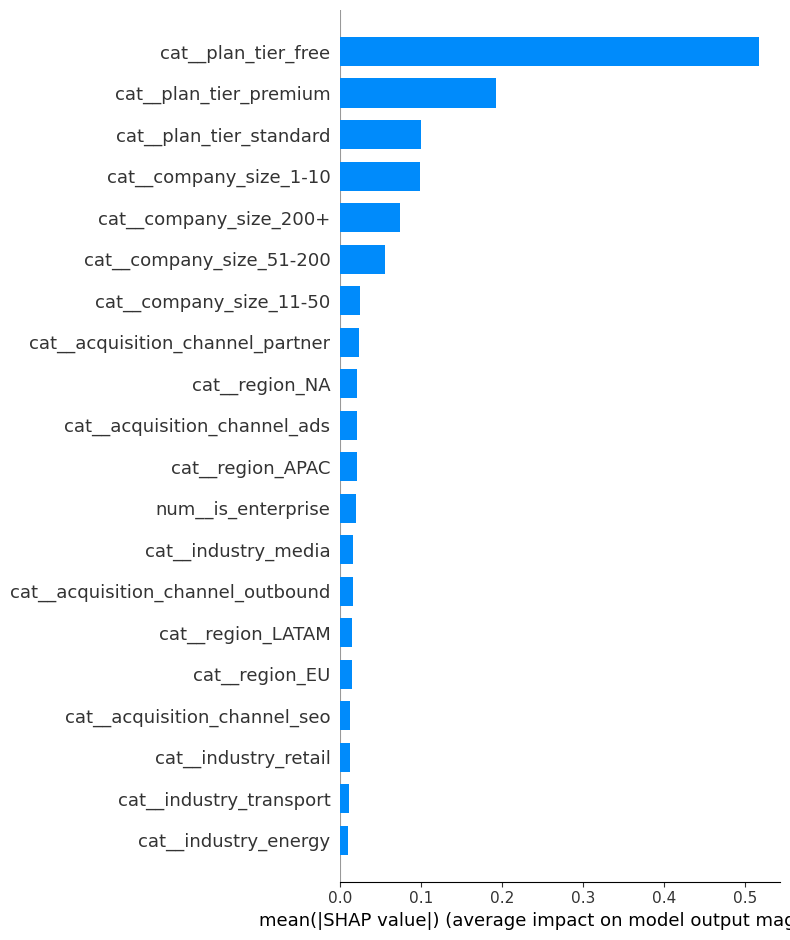

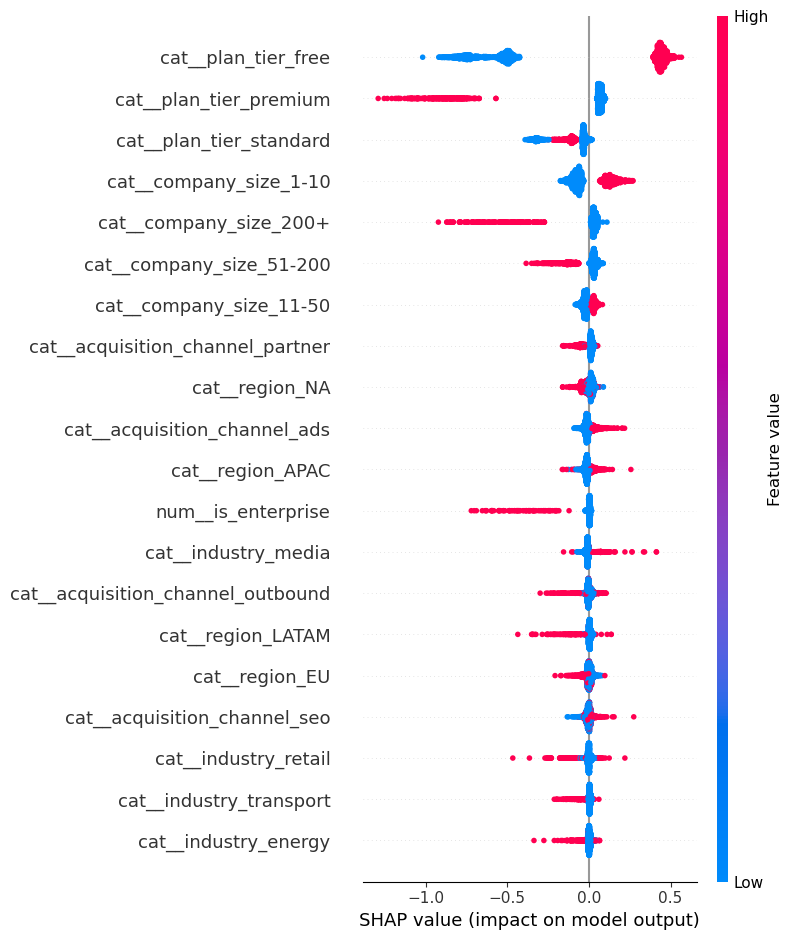

ValueError: Please reshape the input data into 2-dimensional matrix.

In [24]:
# !pip install shap  # run once if needed
import shap

# Transform sets with the *fitted* preprocessor (no SMOTE at inference)
X_tr_pre = pre_fitted.transform(X_train)
X_te_pre = pre_fitted.transform(X_test)

# Explain the XGB model on the preprocessed matrix
explainer = shap.TreeExplainer(xgb_fitted)
# sample to keep it fast
sample_idx = np.random.choice(X_te_pre.shape[0], size=min(2000, X_te_pre.shape[0]), replace=False)
shap_values = explainer.shap_values(X_te_pre[sample_idx])

# Summary bar: global drivers
shap.summary_plot(shap_values, features=X_te_pre[sample_idx], feature_names=feat_names, plot_type="bar")

# Detailed summary (beeswarm)
shap.summary_plot(shap_values, features=X_te_pre[sample_idx], feature_names=feat_names)

# Single user explanation (top at-risk)
i = int(np.argmax(y_prob))   # index of highest predicted churn in test set
shap.force_plot(explainer.expected_value, explainer.shap_values(X_te_pre[i]), 
                matplotlib=True, features=X_te_pre[i], feature_names=feat_names)


In [25]:
import numpy as np
import pandas as pd

# choose your tier cuts
def risk_tier(p):
    if p > 0.60:  return "High"
    if p >= 0.30: return "Medium"
    return "Low"

tiers = pd.Series(y_prob, index=X_test.index).map(risk_tier)
seg = pd.DataFrame({
    "user_id": X_test.index,
    "risk_tier": tiers.values,
    "churn_prob": y_prob,
    "true": y_test
})

# metrics per tier
tier_metrics = (seg
    .groupby("risk_tier")
    .agg(users=("user_id","count"),
         avg_prob=("churn_prob","mean"),
         true_rate=("true","mean"))
    .sort_values("avg_prob", ascending=False))
print(tier_metrics)

# export lists for ops
seg.sort_values("churn_prob", ascending=False).to_csv("churn_risk_segments.csv", index=False)
print("Saved churn_risk_segments.csv")


           users  avg_prob  true_rate
risk_tier                            
High        6780  0.634734   0.332301
Medium      8980  0.464401   0.225501
Low         4240  0.139189   0.075472
Saved churn_risk_segments.csv


KeyError: "None of [Index([66110, 90839, 65861, 21611, 99612, 73724, 38328, 48543, 47662, 46483,\n       ...\n       45865, 91229, 46628, 72784, 21088, 75821, 52391,  3680,  5258, 57095],\n      dtype='int64', length=20000)] are in the [index]"